# Title

In [2]:
"""markdown
    TITLE   :
    AUTHOR  :
    PROJECT :
""";

__author__ = ''
__version__ = ''

<br><br>

- - - 
- - - 


# Prepare

## Imports

In [3]:
from astroPHD import ipython
ipython.run_imports(base=True, astropy=True, matplotlib=True, galpy=True, verbose_imports=False)
from astropy import constants



# GENERAL
import pandas as pd

# CUSTOM

# PROJECT-SPECIFIC

set autoreload to 1
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_interppotential_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_integrate_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_integrate_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_integrate_c.cpython-37m-darwin.so
  Reason: image not found' 


<br><br>

- - - 
- - - 


# Code

In [11]:
drct = "../scripts/get_globular_clusters/result.ecsv"
# summary_table = pd.read_csv(drct, sep='\t')
# summary_table = summary_table.iloc[1:,:]
# summary_table.rename(columns={'# Name ':'Name'}, inplace=True)
# summary_table['Name'] = summary_table['Name'].str.strip()
# summary_table.set_index('Name', inplace=True)
# summary_table.head()
summary_table = QTable.read(drct)
summary_table

Name,ra,dec,dist,vlos,vloserr,sigma,rmax,pmra,pmdec,pmra_e,pmdec_e,pmcorr,nstar,rscale,pmdisp,pmscale,pmscale_e
,deg,deg,kpc,km / s,km / s,km / s,arcmin,mas / yr,mas / yr,mas / yr,mas / yr,,,arcmin,mas / yr,mas / yr,mas / yr
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC_104_47Tuc,6.02363,-72.081,4.5,-17.2,0.2,12.2,40.0,5.237,-2.524,0.039,0.039,-0.002,23917.2,18.3,0.418,0.399,0.016
NGC_288,13.1885,-26.582,8.9,-44.8,0.1,3.3,12.0,4.267,-5.636,0.054,0.053,0.018,2555.2,6.05,0.082,0.227,0.017
NGC_362,15.8094,-70.848,8.6,223.3,0.3,8.8,12.0,6.73,-2.535,0.053,0.052,-0.004,1741.3,7.8,0.149,0.229,0.026
Whiting_1,30.7375,-3.2527,30.1,-130.4,1.8,0.3,3.0,-0.234,-1.782,0.115,0.094,-0.05,11.1,0.48,0.0,2.71,2.451
NGC_1261,48.0675,-55.216,16.3,71.4,0.2,5.8,10.0,1.632,-2.038,0.057,0.057,0.009,541.7,4.1,0.093,0.153,0.0
Pal_1,53.3335,79.581,11.1,-75.4,0.2,0.5,3.0,-0.171,0.07,0.074,0.081,0.003,51.0,0.68,0.0,0.507,0.252
AM_1,58.7595,-49.615,123.3,118.0,14.1,1.2,2.5,0.387,-0.406,0.129,0.167,-0.073,39.7,0.37,0.0,0.794,0.045
Eridanus,66.1854,-21.186,90.1,-23.8,1.1,0.7,4.0,0.493,-0.402,0.084,0.087,-0.133,15.0,0.78,0.0,0.182,0.138


/Users/nathanielstarkman/miniconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_actionAngle_c.cpython-37m-darwin.so
  Reason: image not found' 
  Referenced from: /Users/nathanielstarkman/Software/dynamics/galpy/galpy_actionAngle_c.cpython-37m-darwin.so
  Reason: image not found' 
/Users/nathanielstarkman/Software/dynamics/galpy/galpy/df/jeans.py:56: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  dens(r)/intFactor(r))

/Users/nathanielstarkman/Software/dynamics/galpy/galpy/potential/PowerSphericalPotential.py:197: RuntimeWarning: invalid value encountered in double_scalars
  return (3.-self.alpha)/4./numpy.pi/r**self.alpha



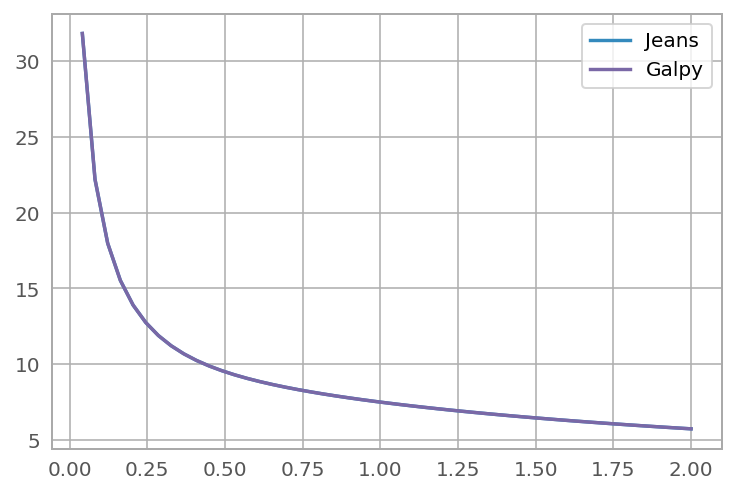

In [12]:
Mgc = 9e5 * u.solMass
mu = (1e5 * u.solMass / Mgc).decompose()
x = np.linspace(0, 2, num=50)
a = 10 * u.pc
G = constants.G

sig2 = -(
    G * Mgc
    * (
        -6 * mu
        - 36 * x ** 2 * mu
        - 70 * x ** 4 * mu
        - 56 * x ** 6 * mu
        - 16 * x ** 8 * mu
        + 48 * x ** 3 * np.sqrt(1 + x ** 2) * mu
        + 48 * x ** 5 * np.sqrt(1 + x ** 2) * mu
        + 16 * x ** 7 * np.sqrt(1 + x ** 2) * mu
        + x * np.sqrt(1 + x ** 2) * (-1 + 16 * mu)
    )
) / (6.0 * a * x * (1 + x ** 2))

plt.plot(x, np.sqrt(sig2).to_value(u.km/u.s), label='Jeans')

gc_pot = potential.PlummerPotential(amp=Mgc, b=a)
bh_pot = potential.KeplerPotential(amp=mu * Mgc)

tot_pot = gc_pot + bh_pot

from galpy.df import jeans

def sigmar(r, tot_pot):
    return jeans.sigmar(tot_pot, r).to_value('km/s')

siggalpy = np.array([sigmar(_x * a, tot_pot) for _x in x]) * u.km / u.s

plt.plot(x, siggalpy.to_value(u.km/u.s), label='Galpy')
plt.legend()

In [14]:
sig2.decompose()

<Quantity [           inf, 1.01181231e+09, 4.92261984e+08, 3.23100065e+08,
           2.40985096e+08, 1.93311696e+08, 1.62590716e+08, 1.41361377e+08,
           1.25919798e+08, 1.14228872e+08, 1.05082498e+08, 9.77259149e+07,
           9.16660419e+07, 8.65695151e+07, 8.22045509e+07, 7.84061793e+07,
           7.50546149e+07, 7.20613506e+07, 6.93599621e+07, 6.68998833e+07,
           6.46421069e+07, 6.25561606e+07, 6.06179505e+07, 5.88082005e+07,
           5.71113113e+07, 5.55145161e+07, 5.40072508e+07, 5.25806800e+07,
           5.12273369e+07, 4.99408478e+07, 4.87157206e+07, 4.75471796e+07,
           4.64310373e+07, 4.53635929e+07, 4.43415521e+07, 4.33619633e+07,
           4.24221659e+07, 4.15197484e+07, 4.06525148e+07, 3.98184563e+07,
           3.90157283e+07, 3.82426309e+07, 3.74975927e+07, 3.67791571e+07,
           3.60859705e+07, 3.54167721e+07, 3.47703853e+07, 3.41457100e+07,
           3.35417160e+07, 3.29574370e+07] m2 / s2>

<br><br>

- - - 
- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>